In [3]:
# Some libraries
from scipy import *
from math import *
from matplotlib.pyplot import *
from functools import *
import sys
from tqdm import tqdm

In [4]:
from sympy.geometry import Point
from sympy.geometry import Polygon as SimpyPolygon
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pyclipper
import functools

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Class and converting functions

In [129]:
class Rectangle:
    """Minimal representation of a rectangle"""
    def __init__(self, point1_x, point1_y, point2_x, point2_y, longueur):
        self.point1_x = point1_x
        self.point1_y = point1_y
        self.point2_x = point2_x
        self.point2_y = point2_y
        self.longueur = longueur
        
    def side_length(self):
        return math.sqrt((self.point2_x - self.point1_x)**2 + (self.point2_y - self.point1_y)**2)
    
    def area(self):
        return abs(self.side_length() * self.longueur)
    
#     def to_rect(self, strategy="Default"):
#         """Convert a minimal rectangle to a full rectangle"""
#         point1 = Point(self.point1_x, self.point1_y)
#         point2 = Point(self.point2_x, self.point2_y)
#         if point1.equals(point2):
#             raise ValueError("Point 1 and point 2 are the same")
#         if self.longueur == 0:
#             raise ValueError("Longueur nulle interdite")
#         longueur = self.longueur
#         vect = (point2.x - point1.x, point2.y - point1.y)
#         distance = point1.distance(point2)
#         vectUnitaire = (vect[0] / distance * longueur, vect[1] / distance * longueur)
#         normalVect = (-vectUnitaire[1], vectUnitaire[0])
#         point3 = Point(point2.x + normalVect[0], point2.y + normalVect[1])
#         point4 = Point(point1.x + normalVect[0], point1.y + normalVect[1])
#         if strategy == "Default":
#             return [point1, point2, point3, point4]
#         else:
#             return SimpyPolygon(point1, point2, point3, point4)
        
    def to_rect(self, strategy="Default"):
        """Convert a minimal rectangle to a full rectangle"""
        vect = (self.point2_x - self.point1_x, self.point2_y - self.point1_y)
        distance = self.side_length()
        vectUnitaire = (vect[0] / distance * self.longueur, vect[1] / distance * self.longueur)
        normalVect = (-vectUnitaire[1], vectUnitaire[0])
        point1 = (self.point1_x, self.point1_y)
        point2 = (self.point2_x, self.point2_y)
        point3 = (self.point2_x + normalVect[0], self.point2_y + normalVect[1])
        point4 = (self.point1_x + normalVect[0], self.point1_y + normalVect[1])
        if strategy == "Default":
            return [point1, point2, point3, point4]
        else:
            return SimpyPolygon(point1, point2, point3, point4)

In [61]:
def path_to_polygon(path):
    """Return a polygon if it is not one yet"""
    if type(path) == list:
        return SimpyPolygon(*path)
    return path

def polygon_to_path(polygon):
    """Return a path if it is not one yet"""
    if type(polygon) == SimpyPolygon:
        return list(map(lambda p: [p.x, p.y], polygon.vertices))
    return polygon

## Drawing functions

In [93]:
def draw_polygon(polygon, ax=None, color="green"):
    """Draw a polygon over an axis (not shown directly)
    
    @param polygon: Whether a polygon or a path
    """
    if ax is None:
        ax = plt.gca()
    if type(polygon) == SimpyPolygon:
        polygon = np.array(list(map(lambda p: [p.x, p.y], polygon.vertices)))
    p = Polygon(polygon, closed=False, color=color, alpha=0.3, lw=0)
    ax.add_patch(p)
    ax.axis('equal')
    return ax

In [94]:
def draw_polygons(polygons, colors=None, verbose=False):
    """Draw polygons and print the figure
    
    @param polygons: SimpyPolygon or list(SimpyPolygon)
    @param colors: colors to match to the polygons
    """
    ax = plt.gca()
    if type(polygons) == SimpyPolygon:
        polygons = [polygons]
    if colors is None:
        colors = ["grey"]*len(polygons)
    if len(colors) > 0 and len(colors) < len(polygons):
        colors = colors + [colors[-1]] * (len(polygons) - len(colors))
    colors.reverse()
    
    for polygon in polygons:
        color = colors.pop()
        if verbose:
            print(color, "Polygon : ", polygon)
        ax = draw_polygon(polygon, ax, color=color)
    plt.show()

## Calculate the area of a polygon

In [95]:
import time
def area(polygon):
    print("entrée: area, type:", type(polygon))
    print("in area, polygon=", polygon)
    start_time = time.time()
    try:
        if type(polygon) == SimpyPolygon:
            res = abs(polygon.area)
            print("--- %s seconds ---" % (time.time() - start_time))
            print("sortie: area")
            return res
        elif type(polygon) == Rectangle:
            side_length = polygon.side_length()
            area = abs(side_length * polygon.longueur)

        #print("In area : ", polygon)
        #print("In area : ", abs(float((sol_to_rect(polygon)).area)))
        
        #poly = sol_to_rect(polygon)
        #res = abs(float((sol_to_rect(polygon)).area))
        print("area1", side_length)
        print("area2", area)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("sortie: area")
        return area
    except:
        printmd("### Error !")
        print(polygon)

def get_bornage_search_field(polygon):
    polygon = polygon_to_path(polygon)
    min_func = lambda acc, vertice: min(min(*vertice),acc)
    max_func = lambda acc, vertice: max(max(*vertice),acc)
    
    min_search_field = functools.reduce(min_func, polygon, sys.maxsize)
    max_search_field = functools.reduce(max_func, polygon, -sys.maxsize)
    
    return min_search_field, max_search_field

print("Test area")
carre = Rectangle(*[0, 0, 10, 0, 10])
print("aire", area(carre))
print(carre.area())

Test area
entrée: area, type: <class '__main__.Rectangle'>
in area, polygon= <__main__.Rectangle object at 0x7f76f3e4eb20>
area1 10.0
area2 100.0
--- 0.00036835670471191406 seconds ---
sortie: area
aire 100.0
100.0


## Calculate the validity of a solution

In [96]:
def vertice_in_polygon(vertice, polygon):
    """ Determine if the vertice is in the polygon
    Not a strict check because of the pyclipper library in which
    the coordinates are floored.
    """
    return list(map(lambda c: int(c), vertice)) in polygon

import time
def is_valid(rectangle, polygon):
    """ Determine if the rectangle is in the polygon
    
    @param rectangle: whether a polygon or a list of vertices
    @param polygon: whether a polygon or a list of vertices
    """
    print("entrée: est_valide")
    start_time = time.time()
    try:
        rectangle, polygon = polygon_to_path(rectangle), polygon_to_path(polygon)
        pc = pyclipper.Pyclipper()
        pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        pc.AddPath(rectangle, pyclipper.PT_CLIP, True)
    
        intersections = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
        
        res = (intersections != []) and (len(intersections[0]) == len(rectangle)) and np.all([vertice_in_polygon(v, intersections[0]) for v in rectangle]) 
        print("--- %s seconds ---" % (time.time() - start_time))
        return res, intersections
    except pyclipper.ClipperException:
        print("Clipper exception")
        return False

House : <__main__.Rectangle object at 0x7f76f90145e0>
Land : Polygon(Point2D(0, 0), Point2D(0, 100), Point2D(100, 100), Point2D(110, 50), Point2D(100, 0))


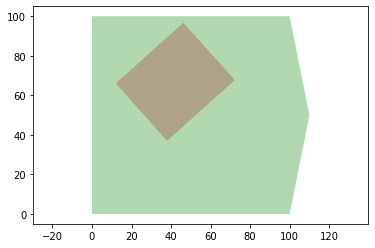

entrée: est_valide
--- 0.010403871536254883 seconds ---


### Validité : C'est bon ça passe

entrée: area, type: <class '__main__.Rectangle'>
in area, polygon= <__main__.Rectangle object at 0x7f76f90145e0>
area1 38.948684188300895
area2 1791.6394726618412
--- 5.555152893066406e-05 seconds ---
sortie: area
entrée: area, type: <class 'sympy.geometry.polygon.Polygon'>
in area, polygon= Polygon(Point2D(0, 0), Point2D(0, 100), Point2D(100, 100), Point2D(110, 50), Point2D(100, 0))
--- 0.00021457672119140625 seconds ---
sortie: area


### L'aire de la maison est de **1791** m² sur 10500 m² possible



green Polygon :  Polygon(Point2D(0, 0), Point2D(0, 100), Point2D(100, 100), Point2D(110, 50), Point2D(100, 0))
brown Polygon :  [Point2D(12, 66), Point2D(38, 37), Point2D(1334*sqrt(1517)/1517 + 38, 1196*sqrt(1517)/1517 + 37), Point2D(12 + 1334*sqrt(1517)/1517, 1196*sqrt(1517)/1517 + 66)]
blue Polygon :  [[72, 67], [46, 96], [12, 66], [38, 37]]


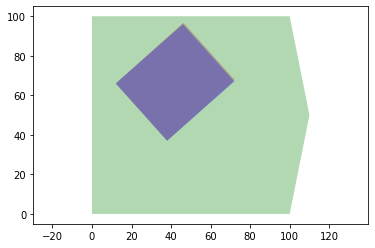

In [110]:
solution = Rectangle(*[12, 66, 38, 37, 46])
house = solution
print("House :", house)

land = SimpyPolygon((0,0), (0,100), (100,100), (110, 50), (100, 0))
print("Land :", land)

# draw the situation
draw_polygons([land, house.to_rect()], colors=["green", "brown"], verbose=False)

# determine if the house is well placed over the land
res, clip = est_valide(house.to_rect(), land)
printmd("### Validité : C'est bon ça passe" if res else "### Validité : Noooooooon, construction incorrecte")
printmd(f"### L'aire de la maison est de **{int(area(house))}** m² sur {area(land)} m² possible\n\n")

# draw the solution to verify it is correct
draw_polygons([land, house.to_rect(), clip[0]], colors=["green","brown","blue"], verbose=True)

In [98]:
get_bornage_search_field(land)

(0, 110)

In [111]:
def polygon_bornage(sol, land_polygon):
    print("entrée: polygon_bornage")
    sol = Rectangle(*sol)
    rect = sol.to_rect()
    if est_valide(rect, land_polygon):
        print(sol)
        printmd("## Est valide")
        return sol 
    else:
        print("this one is invaid")
        print(sol)
        raise ValueError("Solution invalide par contrainte de bornage")

In [112]:
# inf, sup = get_bornage_search_field(land)
# PSO_fit(eval_function=area, 
#         bornage_function=lambda x: polygon_bornage(x, land), 
#         log_function=lambda x:draw_polygons([land, sol_to_rect(x)], colors=["green", "brown"]), 
#         nb_particle=20, 
#         dim=5, inf=inf, sup=sup, 
#         nb_cycles=3)

entrée: area, type: <class '__main__.Rectangle'>
in area, polygon= <__main__.Rectangle object at 0x7f76f334a280>
area1 72.59650273671927
area2 4586.606008355868
--- 0.0002243518829345703 seconds ---
sortie: area
4586.606008355868


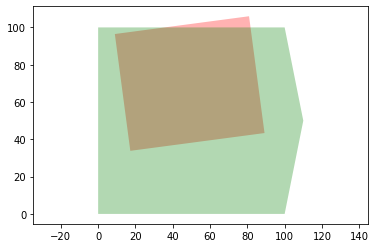

In [138]:
sol = Rectangle(*[17.238688824344802, 33.826900857585485, 89.20655264720808, 43.35993743447405, 63.179434758583284])
print(area(sol))
draw_polygons(polygons=[sol.to_rect(), land], colors=["red", "green"])

In [102]:
Nb_cycles = 2000
Nb_particle = 20
# usual params
psi,cmax = (0.7, 1.47) 
# psi,cmax = (0.8, 1.62)

### Calcul de temps

In [137]:
st = time.time()
for sol in pick_random_sol(land, 50):
    sol = Rectangle(*sol).to_rect(strategy="Default")
print(time.time() - st)

3.152130365371704


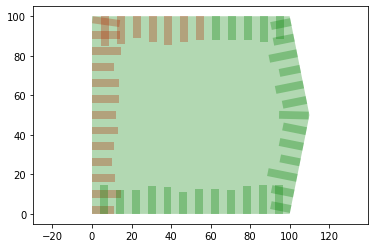

entrée: est_valide
--- 0.005158901214599609 seconds ---
entrée: est_valide
--- 0.009629249572753906 seconds ---
entrée: est_valide
--- 0.009185791015625 seconds ---
entrée: est_valide
--- 0.00932168960571289 seconds ---
entrée: est_valide
--- 0.008704662322998047 seconds ---
entrée: est_valide
--- 0.009739875793457031 seconds ---
entrée: est_valide
--- 0.009500265121459961 seconds ---
entrée: est_valide
--- 0.008628606796264648 seconds ---
entrée: est_valide
--- 0.008142948150634766 seconds ---
entrée: est_valide
--- 0.0076160430908203125 seconds ---
entrée: est_valide
--- 0.008852958679199219 seconds ---
entrée: est_valide
--- 0.008391618728637695 seconds ---
entrée: est_valide
--- 0.10392546653747559 seconds ---
entrée: est_valide
--- 0.025049448013305664 seconds ---
entrée: est_valide
--- 0.025789976119995117 seconds ---
entrée: est_valide
--- 0.026552438735961914 seconds ---
entrée: est_valide
--- 0.02507925033569336 seconds ---
entrée: est_valide
--- 0.02422046661376953 seconds --

In [115]:
from sympy import Symbol
def pick_random_sol(land, size=1, delta=0.05, stochastic=False):
    t = Symbol('t', real=True)
    p = land.arbitrary_point('t')
    if stochastic:
        picks = sorted([random.rand() for i in range(size*2)])
    else:
        picks = np.linspace(0, 1, size*2+1)
    points_on_perimeter = [p.subs(t, pick) for pick in picks]
    #picks = [pick + delta if pick + delta < 1 else pick + (1 - pick) / 2 for pick in picks]
    #second_points_on_perimeter = [p.subs(t, pick) for pick in picks]
    return [[points_on_perimeter[i*2].x, points_on_perimeter[i*2].y, points_on_perimeter[i*2+1].x, points_on_perimeter[i*2+1].y, -10-delta*100*random.rand()] for i in range(size)]
    # return p.subs(t, (s1 + s2/2)/perimeter)
sols = [Rectangle(*sol).to_rect() for sol in pick_random_sol(land, 50)]
draw_polygons([*sols, land], colors=["red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "green"])
print([est_valide(sol, land)[0] for sol in sols])

In [104]:
# Initialization

# create a particle 
# one particle is discribed by : 
#   - pos : solution list of variables
#   - vit : movement velocity (null at the initialization)
#   - fit :  fitness of the solution
#   - bestpos : best visited position 
#   - bestfit : evaluation of the best visited solution
#   - bestvois : best neighbor (global for this version)
# def initOne(dim,inf,sup, eval_func=FUNCTION):
#     pos = [random.uniform(inf, sup) for i in range(dim)]
#     fit = eval(pos, eval_func)
#     return {'vit':[0]*dim, 'pos':pos, 'fit':fit, 'bestpos':pos, 'bestfit':fit, 'bestvois':[]}


# Init of the population (swarm)
def initSwarm(nb,dim,eval_func,land=None):
    print("entrée: initSwarm")
    #return [initOne(dim,inf,sup) for i in range(nb)]
    positions = pick_random_sol(land, nb)
    fits = [eval_func(pos) for pos in positions]
    print("sortie: initSwarm")
    return [{'vit':[0]*dim, 'pos':positions[i], 'fit':fits[i], 'bestpos':positions[i], 'bestfit':fits[i], 'bestvois':[]} for i in range(nb)]

In [105]:
# Return the particle with the best fitness
def maxParticle(p1,p2):
    if (p1["fit"] > p2["fit"]):
        return p1 
    else:
        return p2

# Returns a copy of the particle with the best fitness in the population
def getBest(swarm):
    return dict(reduce(lambda acc, e: maxParticle(acc,e),swarm[1:],swarm[0]))

In [90]:
# Update information for the particles of the population (swarm)
def update(particle,bestParticle):
    nv = dict(particle)
    if(particle["fit"] > particle["bestfit"]):
        nv['bestpos'] = particle["pos"][:]
        nv['bestfit'] = particle["fit"]
    nv['bestvois'] = bestParticle["bestpos"][:]
    return nv

# Calculate the velocity and move a particule
def move(particle, dim, eval_function, bornage_function):
    global ksi,c1,c2,psi,cmax

    print("entrée: move")
    nv = dict(particle)

    velocity = [0]*dim
    for i in range(dim):
        velocity[i] = (particle["vit"][i]*psi + \
        cmax*random.uniform()*(particle["bestpos"][i] - particle["pos"][i]) + \
        cmax*random.uniform()*(particle["bestvois"][i] - particle["pos"][i]))

    new_pos = [particle["pos"][i] + velocity[i] for i in range(dim)]
    try:
        position = bornage_function(new_pos)
    except ValueError:
        print("Debug: ", new_pos, "is an incorrect solution")
        position = particle["pos"]

    nv['vit'] = velocity
    nv['pos'] = position
    nv['fit'] = eval_function(position)

    print("sortie: move")
    return nv

In [91]:
# MAIN LOOP
LAND = land
def fit(eval_function, bornage_function, nb_particle=Nb_particle, dim=5, nb_cycles=Nb_cycles, log_function=print):
    Htemps = []       # temps
    Hbest = []        # distance

    # initialization of the population
    swarm = initSwarm(nb_particle,dim,eval_func=eval_function, land=LAND)
    draw_polygons([land]+[sol_to_rect(sol["pos"]) for sol in swarm], colors=["green", "red"])
    # initialization of the best solution
    best = getBest(swarm)
    best_cycle = best

    for i in tqdm(range(nb_cycles)):
        #Update informations
        swarm = [update(e,best_cycle) for e in swarm]
        # velocity calculations and displacement
        swarm = [move(particle=e, dim=dim, eval_function=eval_function, bornage_function=bornage_function) for e in swarm]
        draw_polygons([land]+[sol_to_rect(sol["pos"]) for sol in swarm], colors=["green", "red"])
        # Update of the best solution
        best_cycle = getBest(swarm)
        if (best_cycle["bestfit"] > best["bestfit"]):
            best = best_cycle
            # draw(best['pos'], best['fit'])

        # historization of data
        if i % 10 == 0:
            Htemps.append(i)
            Hbest.append(best['bestfit'])
            
        log_function(best['pos'])

    # END, displaying results
    Htemps.append(i)
    Hbest.append(best['bestfit'])

    #displaying result on the console
    dispRes(best)

entrée: initSwarm
sortie: initSwarm


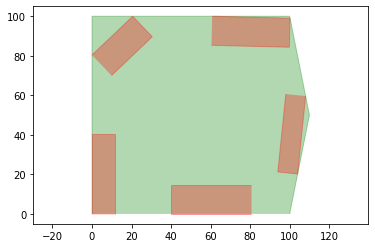

  0%|          | 0/200 [00:00<?, ?it/s]

entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.2808518409729004 seconds ---
[-20.3125229948393*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 20.3125229948393, 0, -10.0231280098647*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 10.0231280098647, 0.431776287213523*sqrt(26) + 6.47664430820284, -11.75822533452276]


## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.34066081047058105 seconds ---
[-117.710005690658*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 117.710005690658, 2.44401004573449*sqrt(26) + 36.6601506860174, -60.8421221728015*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 39.1578778271985*(3/10 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 60.8421221728015, -27.6467986130007, -14.376093928301446]


## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.46834492683410645 seconds ---
[-51.1192296961195*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 48.8807703038805*(2/5 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 51.1192296961195, -16.6890616096768, -141.067504084253*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) - 0.0157951938785588*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 100, -0.14140402449308*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 73.5300927364015, -14.666966613249512]


## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.4028329849243164 seconds ---
[-25.203562912299*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 0.0287678604183466*sqrt(26)*(3/5 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 100, -11.7642552960064 + 0.0226235678769353*sqrt(26)*(3/5 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300), -121.458666547123*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 0.008253333287355*sqrt(26)*(20*sqrt(26) + 300)*(-200/(20*sqrt(26) + 300) - 10*sqrt(26)/(20*sqrt(26) + 300) + 7/10) + 97.8541333452877, -0.0622563262923308*sqrt(26)*(20*sqrt(26) + 300)*(-200/(20*sqrt(26) + 300) - 10*sqrt(26)/(20*sqrt(26) + 300) + 7/10) + 16.186644836006, -13.583824038798838]


## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.1619398593902588 seconds ---
[-100*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 100, 0, -100*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 100, 0, -14.584131959089879]


## Est valide

sortie: move


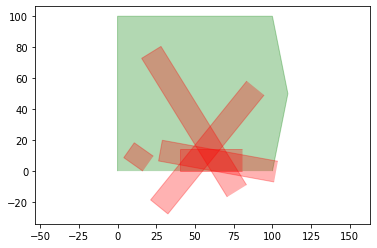

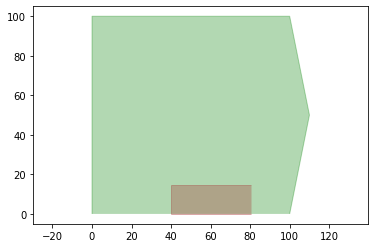

  0%|          | 1/200 [00:04<14:03,  4.24s/it]

entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.2790236473083496 seconds ---
[-15.2533077788146 + 15.2533077788146*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 126.277636952546*(2/5 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3), 110.528903024513, -4.3740126338698*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 0.033260715025466*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 90.8518717000815, -0.247964770647467*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) - 0.0124161126608962*sqrt(26) + 128.755439046769, -12.108683465644154]


## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.6266326904296875 seconds ---
[-173.790661714616*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 22.3569337246169*(2/5 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 173.790661714616, 89.8303896468963 - 1.3272002987831*sqrt(26), -90.7669414465743*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) - 11.5825635762866*(3/10 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 0.0080060085114278*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 111.582563576287, -0.252286172920989*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 50.4587583578878, -14.718168814613724]


## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.5477116107940674 seconds ---
[-30.0990427048741*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 30.0990427048741 + 69.9009572951259*(2/5 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3), 46.3170355767463, -89.1324712993093*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 0.00417981873103489*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 100, -0.112475902542634*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 58.4874693221698, -14.68801059836572]


## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 1.0418775081634521 seconds ---
[-33.5667477556325*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 0.0113906931376101*sqrt(26)*(3/5 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 36.8174500865813*(2/5 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 63.1825499134187, -29.4756004110037 + 0.160824122163426*sqrt(26)*(3/5 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300), -67.5246385350906*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 0.0440020203343786*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 0.0315114966940289*sqrt(26)*(20*sqrt(26) + 300)*(-200/(20*sqrt(26) + 300) - 10*sqrt(26)/(20*sqrt(26) + 300) + 7/10) + 91.8070108595525, -0.0933965998446624*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 0.0590151817299447*sqrt(26)*(20*sqrt(26) + 300)*(-200/(20*sqrt(26) + 300) - 10*sqrt(26)/(20*sqrt(26) + 300) + 7/10) +

## Est valide

sortie: move
entrée: move
entrée: polygon_bornage
entrée: est_valide
--- 0.5772523880004883 seconds ---
[-95.0990425437467*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 4.90095745625327*(2/5 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 95.0990425437467, 52.0711362027438, 0.0560115809758592*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 45.630110537234*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 100, -0.0585402972524522*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 30.4409545712752, -14.645223024476921]


## Est valide

sortie: move


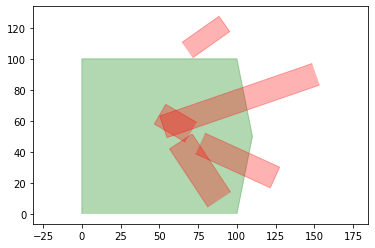

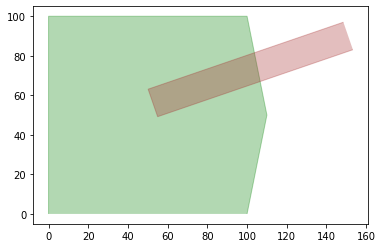

  1%|          | 2/200 [00:11<17:19,  5.25s/it]

entrée: move
entrée: polygon_bornage


  1%|          | 2/200 [00:12<20:13,  6.13s/it]


KeyboardInterrupt: 

In [92]:
fit(eval_function=lambda x: Rectangle(*x).area(), 
    bornage_function=lambda x: polygon_bornage(x, land), 
    log_function=lambda x:draw_polygons([land, sol_to_rect(x)], colors=["green", "brown"]),
    nb_particle=5, 
    dim=5, 
    nb_cycles=200)